In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import export_text

In [3]:
np.random.seed(306)

In [4]:
cv = ShuffleSplit(n_splits=10, test_size= 0.2, random_state= 42)

In [5]:
# fetch dataset
features, labels = fetch_california_housing(as_frame= True, return_X_y= True)

# train-testt split
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels,
                                                                                     random_state= 42)

# train --> train + dev split
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state= 42)


In [6]:
dt_reg_pipeline= Pipeline(steps=[
    ('features_scaling', StandardScaler()),
    ('dt_reg', DecisionTreeRegressor(max_depth= 3, random_state= 42))
])
dt_reg_cv_results = cross_validate(dt_reg_pipeline,
                                   com_train_features, 
                                   com_train_labels,
                                   cv= cv,
                                   scoring='neg_mean_absolute_error',
                                   return_train_score= True,
                                   return_estimator= True)
dt_reg_train_error = -1 * dt_reg_cv_results['train_score']
dt_reg_test_error = -1 * dt_reg_cv_results['test_score']
print(f'Mean absolute error of linear regression model on the train set:\n',
      f'{dt_reg_train_error.mean():.3f} +/- {dt_reg_train_error.std():.3f}')

print(f'Mean absolute error of linear regression model on the test set:\n',
      f'{dt_reg_test_error.mean():.3f} +/- {dt_reg_test_error.std():.3f}')

Mean absolute error of linear regression model on the train set:
 0.590 +/- 0.005
Mean absolute error of linear regression model on the test set:
 0.593 +/- 0.007


### Visualizing the tree

In [7]:
dt_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('features_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=3, random_state=42))])

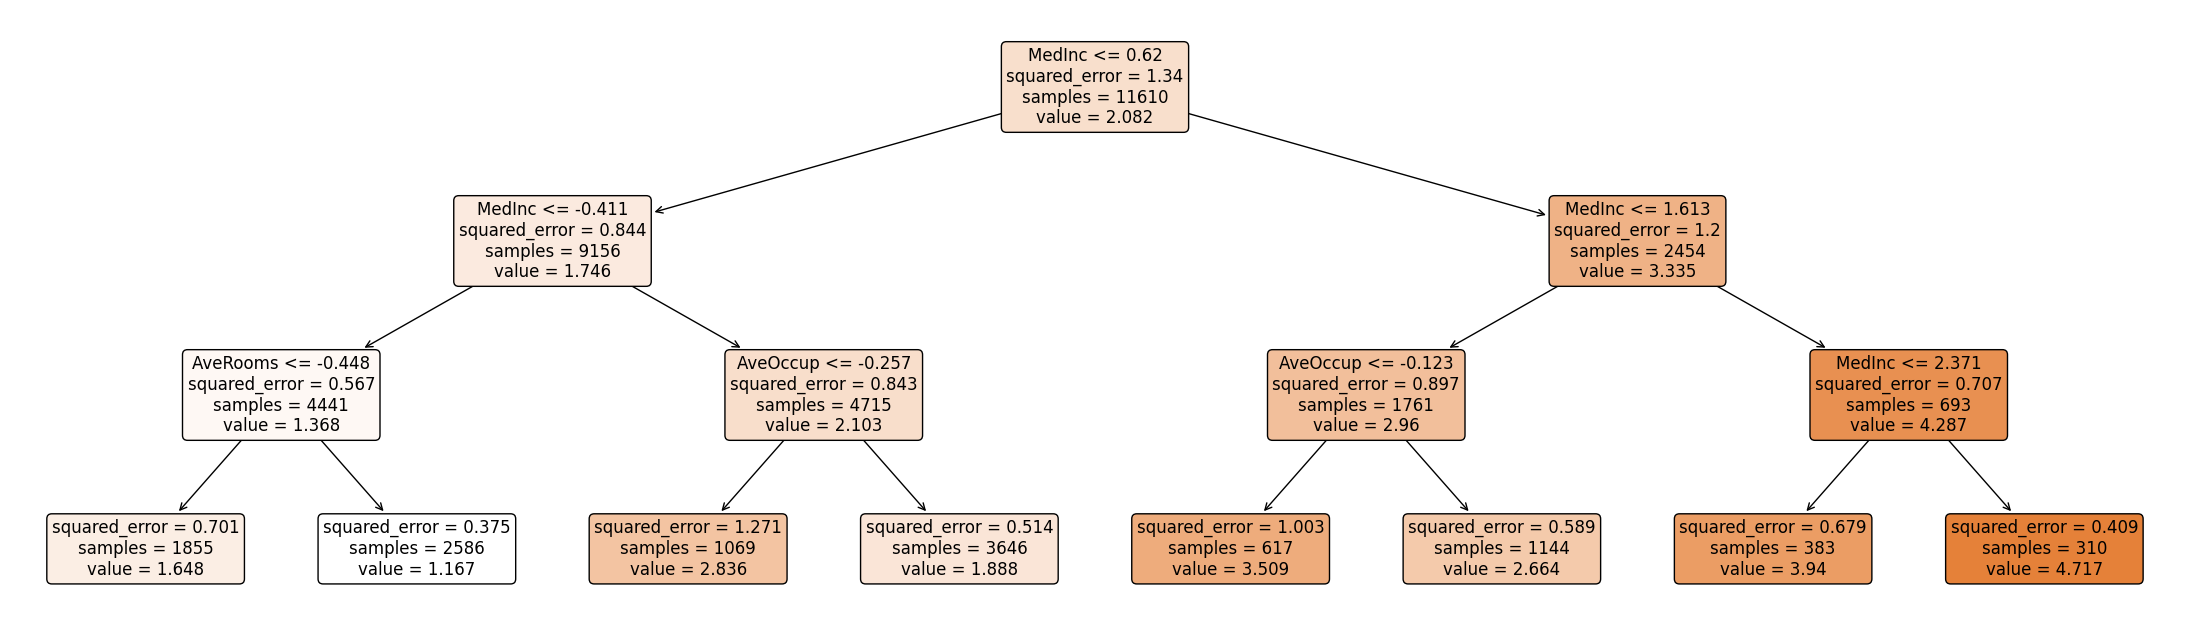

In [8]:
plt.figure(figsize= (28, 8), facecolor= 'w')
a = tree.plot_tree(dt_reg_pipeline[-1],
                   feature_names= features.columns,
                   rounded= True,
                   filled= True,
                   fontsize= 12)

### Tree text export

In [9]:
tree_rules = export_text(dt_reg_pipeline[-1])
print(tree_rules)

|--- feature_0 <= 0.62
|   |--- feature_0 <= -0.41
|   |   |--- feature_2 <= -0.45
|   |   |   |--- value: [1.65]
|   |   |--- feature_2 >  -0.45
|   |   |   |--- value: [1.17]
|   |--- feature_0 >  -0.41
|   |   |--- feature_5 <= -0.26
|   |   |   |--- value: [2.84]
|   |   |--- feature_5 >  -0.26
|   |   |   |--- value: [1.89]
|--- feature_0 >  0.62
|   |--- feature_0 <= 1.61
|   |   |--- feature_5 <= -0.12
|   |   |   |--- value: [3.51]
|   |   |--- feature_5 >  -0.12
|   |   |   |--- value: [2.66]
|   |--- feature_0 >  1.61
|   |   |--- feature_0 <= 2.37
|   |   |   |--- value: [3.94]
|   |   |--- feature_0 >  2.37
|   |   |   |--- value: [4.72]



In [10]:
test_labels_pred = dt_reg_pipeline.predict(test_features)

In [11]:
mae = mean_absolute_error(test_labels, test_labels_pred)
mse = mean_squared_error(test_labels, test_labels_pred)
r2 = r2_score(test_labels, test_labels_pred)

print('The model performance for testing set')
print(*['_' for i in range(10)], sep='')
print('MAE is ', mae)
print('MSE is ', mse)
print('R2 score is: ', r2)


The model performance for testing set
__________
MAE is  0.6005762942842664
MSE is  0.6417557936098145
R2 score is:  0.5150037690483743


In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
param_grid = {
    'dt_reg__max_depth': range(1, 20),
    'dt_reg__min_samples_split': range(2, 8)
}
dt_grid_search = GridSearchCV(dt_reg_pipeline,
                              param_grid= param_grid,
                              n_jobs= 2,
                              cv= cv,
                              scoring= 'neg_mean_absolute_error',
                              return_train_score= True)
dt_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('features_scaling', StandardScaler()),
                                       ('dt_reg',
                                        DecisionTreeRegressor(max_depth=3,
                                                              random_state=42))]),
             n_jobs=2,
             param_grid={'dt_reg__max_depth': range(1, 20),
                         'dt_reg__min_samples_split': range(2, 8)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [14]:
dt_grid_search.best_params_

{'dt_reg__max_depth': 11, 'dt_reg__min_samples_split': 5}

In [15]:
mean_train_error = -1 * dt_grid_search.cv_results_['mean_train_score'][dt_grid_search.best_index_]
mean_test_error = -1 * dt_grid_search.cv_results_['mean_test_score'][dt_grid_search.best_index_]
std_train_error = -1 * dt_grid_search.cv_results_['std_train_score'][dt_grid_search.best_index_]
std_test_error = -1 * dt_grid_search.cv_results_['std_test_score'][dt_grid_search.best_index_]

print(f'Best mean absolute error of decision tree regression model on the train set: \n',
      f'{mean_train_error:.2f} +/- {std_train_error:.3f}')
print(f'Mean absolute error of decisioin tree regression model on the test set: \n',
      f'{mean_test_error:.3f} +/- {std_test_error:.3f}')

Best mean absolute error of decision tree regression model on the train set: 
 0.28 +/- -0.006
Mean absolute error of decisioin tree regression model on the test set: 
 0.428 +/- -0.012
